# Udacity Capstone Project - Dog Breed Identification

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

import datetime as dt
import tensorflow as tf

from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input, InceptionV3, decode_predictions
from keras.applications.xception import preprocess_input, Xception, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

import pickle

%matplotlib inline

### Initialize project level variables

In [3]:
DEBUG = False
# recommended input size for inception architecture
INPUT_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_OF_CLASSES = 120 if(not DEBUG) else 4
TRAIN_IMAGE_DIR = "./input/train/"

## Analyse data

In [4]:
labels_filename = "./input/labels.csv"
labels_data = pd.read_csv(labels_filename, delimiter=",")
breed_size = labels_data.groupby("breed").size()
print(breed_size.values)
print("max {}, min {}, mean {}".format(breed_size.max(), breed_size.min(),breed_size.mean()))


[ 80 116  86 107  74  78 102 110  82 105  89 114  77 102  85  85  72  91
  75  87  86  75  67  66  73  75 106  76  83  71  93  80  74  87  72  89
  76  80  74  86  83  75 115  66  72  70  69  75  69  67  81  75 111  82
  82  91  88  82  78 101  92 105  81  86  82  67  71  84  99 106  90  81
  73 117  80 102  79  78  91  83  95  78  87  69  96  75  92 111  94  72
  88  76  84  99 109  86  82 126  88  76 112  95  90  71  79  79  72  78
  69 107  80  79  70  69  85  79  81  95  82  82]
max 126, min 66, mean 85.18333333333334


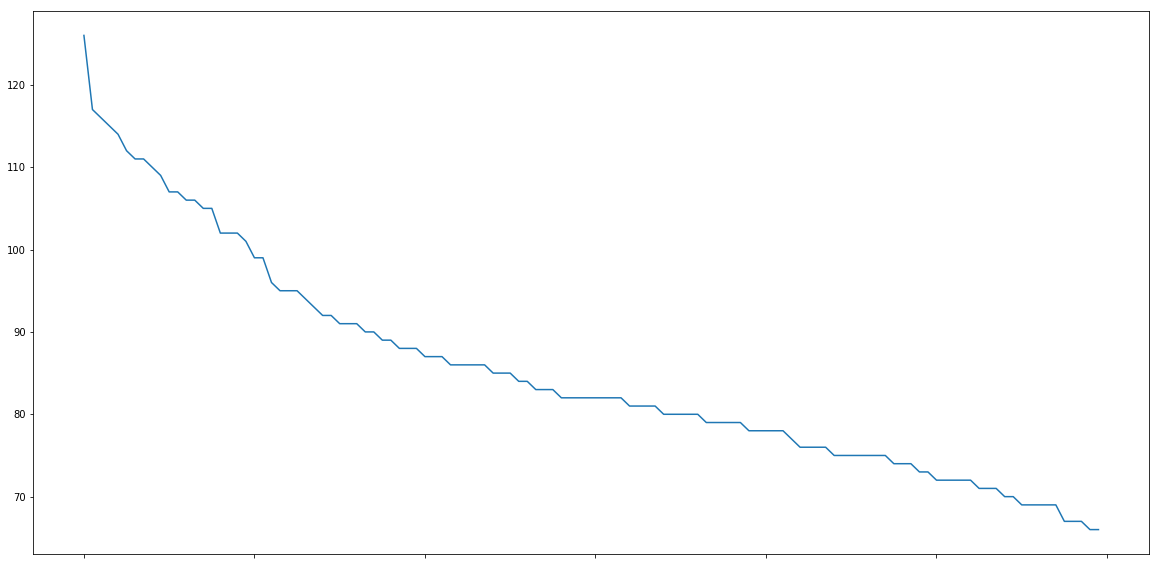

In [13]:
plt.figure(figsize=(20,10))
labels_data['breed'].value_counts().plot.line()

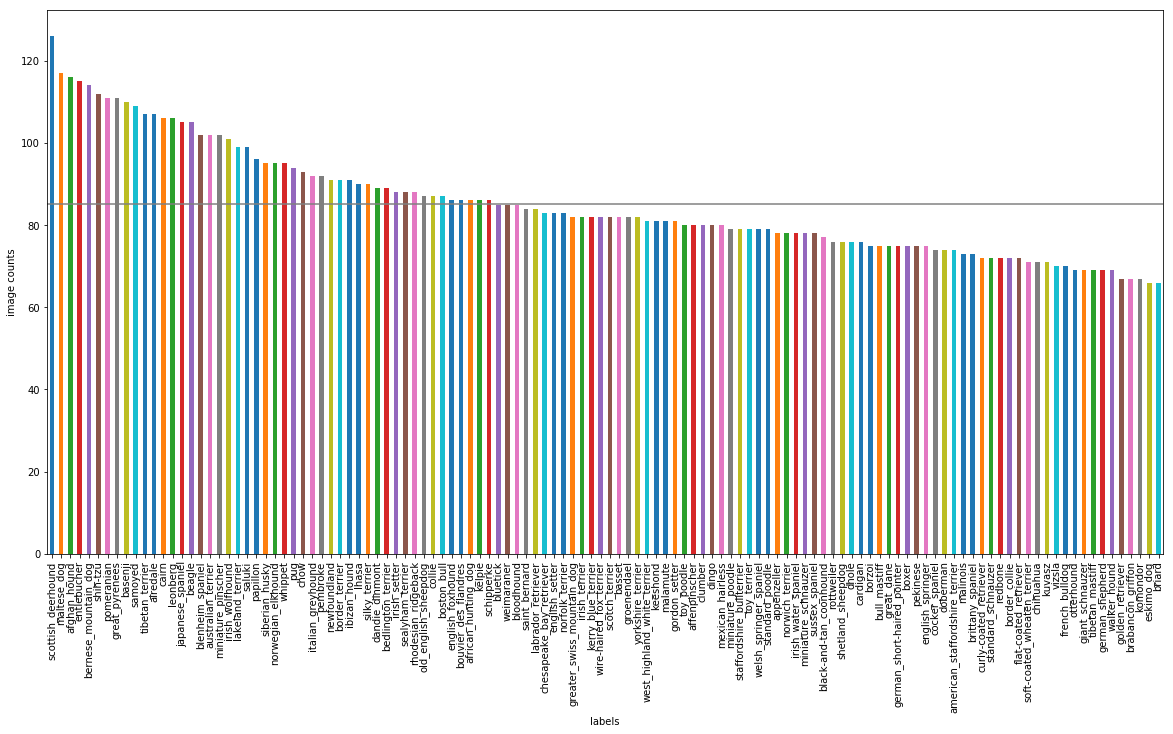

In [120]:
plt.figure(figsize=(20,10))
plt.axhline(breed_size.mean(), color="gray")
plt.xlabel("labels")
plt.ylabel("image counts")
labels_data['breed'].value_counts().plot.bar()

From above, it is clear that minimum number of training data for a breed is 66 images. None of the breed has a very large training set. on average a breed has 85 images. This is a very small dataset for training a convolution neural net from scratch. We would get much better result by using a pretrained model for this problem. 

In [5]:
label_classes = labels_data.breed.unique()
label_classes.sort()
print(label_classes)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

### Display some images with breed

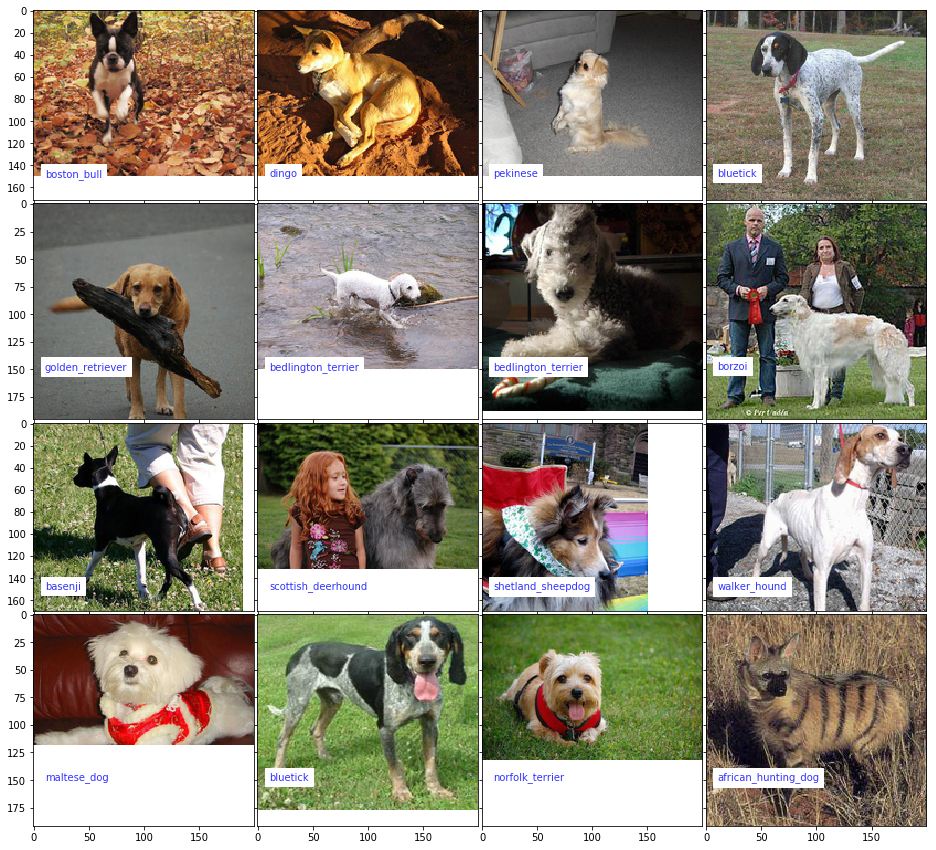

In [6]:
total_records = len(labels_data.id)
# print(idx_arr)

rows = 4
cols = 4
idx_arr = np.ceil(np.random.random((rows * cols)) * total_records)
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.05)

for i, idx in enumerate(idx_arr):
    col = i % cols
    row = i // rows
    title = labels_data.breed[i]
#     print(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
#     image = plt.imread(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
    img = Image.open(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
    img.thumbnail((200, 200), Image.ANTIALIAS)
    grid[i].imshow(img)
    grid[i].text(10, 150, title, color='b', backgroundcolor='w', alpha=0.8 )
plt.show()
    

From above set of images, it is clear that -
* we have dog images in various different situations and it is mixed with images of other people in it. 
* Moreover resolution of all the images is not same. 
* It is a mixed set of pet dogs vs wild dogs. pet dogs are sometimes wearing leash or some clothing.

### Choose Smaller set for Debug

In [7]:
if(DEBUG==True):
#   take biggest set of data for few breeds
    labels_group_size = labels_data.groupby('breed').size().sort_values(ascending=False)
    print(labels_group_size)                         
    selected_breed_list = list(labels_group_size.head(NUM_OF_CLASSES).index)
    print("selected breeds for debugging ", str(selected_breed_list))
    labels = labels_data[labels_data['breed'].isin(selected_breed_list)]
else:
    labels = labels_data
print("shape of labels", labels.shape)

shape of labels (10222, 2)


## Split into Train and Validation set
split the data into 80% train data and 20% validation data.

In [8]:
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)
print(train_labels.shape)
print(val_labels.shape)

(8177, 2)
(2045, 2)


### Load the images into an array and preprocess for feeding to model

In [9]:
def load_preprocess_image(image_id, size, filedir):
    filename = filedir + image_id + ".jpg"
    img = image.load_img(filename, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

### Predict using Keras Xception model

In [10]:
def predictions_xception(y_train, model, batch_size, filedir):
    # process 32 images at a time to keep the memory usage low
    # initialize x train, x_val to the required size 
    iterations = int(np.ceil(len(y_train)/BATCH_SIZE))
    predict_train = np.zeros((len(y_train), 2048), dtype=float)

    for idx in range(iterations):
        iteration_size = BATCH_SIZE if (idx<iterations-1) else (len(y_train) - idx * BATCH_SIZE)
        x_train = np.zeros((iteration_size, INPUT_SIZE[0], INPUT_SIZE[1], 3), dtype=float)
        start_idx = idx * BATCH_SIZE
        end_idx = start_idx + iteration_size

        for idx1, image_id in enumerate(y_train[start_idx:end_idx]):
            x_train[idx1] = load_preprocess_image(image_id, INPUT_SIZE, filedir)

        predict_train[start_idx:end_idx] = model.predict(x_train, verbose=1)
    return predict_train
        


In [11]:
y_train = train_labels['id']
y_val = val_labels['id']
model = Xception(weights='imagenet', include_top=False, pooling='avg')

predict_train = predictions_xception(y_train, model, BATCH_SIZE, "./input/train/")
predict_val = predictions_xception(y_val, model, BATCH_SIZE, "./input/train/")

print(predict_train.shape)
print(predict_val.shape)
print(predict_train.size)
print(predict_val.size)


32/32 [==============================] - 25s 791ms/step


32/32 [==============================] - 25s 767ms/step


29/29 [==============================] - 22s 765ms/step
(8177, 2048)
(2045, 2048)
16746496
4188160


### Checkpoint1 - Save Xception predictions

In [27]:
# save predictions in file
predict_train_file = 'checkpoint_1.pickle'
params_cp1 = {"predict_train":predict_train, "predict_val":predict_val, "train_labels":train_labels}
with open(predict_train_file, 'wb') as handle:
    pickle.dump(params_cp1, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_checkpoint1():
    with open(predict_train_file, 'rb') as handle:
        load_cp1 = pickle.load(handle)
        predict_train = load_cp1['predict_train']
        predict_val = load_cp1['predict_val']
        train_labels = load_cp1['train_labels']

# print(params['predict_train'] == b['predict_train'])
# print(params['predict_val'] == b['predict_val'])

### Load Checkpoint1

uncomment below and execute cell to load checkpoint 1 data

In [ ]:
# load_checkpoint1()

### Train Logistics Regression on Xception output

In [28]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg.fit(predict_train, train_labels['breed'])
valid_probs = logreg.predict_proba(predict_val)
valid_preds = logreg.predict(predict_val)
print(valid_preds)
print(val_labels['breed'].values)
print('train Xception LogLoss {}'.format(log_loss(train_labels['breed'], logreg.predict_proba(predict_train))))
print('train Xception Accuracy {}'.format(accuracy_score((train_labels['breed'].values), logreg.predict(predict_train))))
print('Validation Xception LogLoss {}'.format(log_loss(val_labels['breed'], valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((val_labels['breed'].values), valid_preds)))

['toy_terrier' 'irish_setter' 'scottish_deerhound' ..., 'irish_setter'
 'golden_retriever' 'labrador_retriever']
['toy_terrier' 'irish_setter' 'scottish_deerhound' ..., 'irish_setter'
 'golden_retriever' 'labrador_retriever']
train Xception LogLoss 0.0444275190619959
train Xception Accuracy 0.998777057600587
Validation Xception LogLoss 0.3348075437973538
Validation Xception Accuracy 0.8987775061124694


* Accuracy of our Xception + Logistic Regression model for validation dataset is 89.9 % and loss score is 0.3348. This is within our target limit.

### Execute model for Test data

We need to store predictions on test data in a file and then upload it to kaggle. The score for test data will be calculated by kaggle. We do not have access to the actual labels for the test data so we can not calculate score ourself.

In [31]:
# predictions for test data
# get list of filenames/ids
import os 

def get_file_ids(dir):
    ids = [f[:-4] for f in os.listdir(dir) if f.endswith('.jpg')]
    return ids



In [161]:
y_test = get_file_ids("./input/test/")
predict_test_Xception = predictions_xception(y_test, model, BATCH_SIZE, "./input/test/")
test_probs = logreg.predict_proba(predict_test_Xception)
test_preds = logreg.predict(predict_test_Xception)
# print(test_probs.shape)
# print(test_preds.sh)

32/32 [==============================] - 30s 925ms/step


32/32 [==============================] - 25s 792ms/step


21/21 [==============================] - 16s 770ms/step


In [162]:
result_file = "./input/submission.csv"

df2 = pd.DataFrame(test_probs, columns=label_classes, index=y_test )
df2.to_csv(result_file, sep=",", float_format="%1.17f", index_label="id")

### Kagle Result

The score for our test result from kaggle is 0.34205. Below is the graph of a log loss function. A log loss of 0.34205 would mean a predicted probability of higher than 0.8.




![Figure 1-1](http://wiki.fast.ai/images/4/43/Log_loss_graph.png "Figure 1-1")


### Validate images from third source

In [105]:
labels_outside = pd.read_csv('./free-form/labels.csv', delimiter=",")
print(labels_outside)
y_outside = get_file_ids("./free-form/images/")
predict_outside_Xception = predictions_xception(y_outside, model, BATCH_SIZE, "./free-form/images/")
outside_probs = logreg.predict_proba(predict_outside_Xception)
outside_preds = logreg.predict(predict_outside_Xception)

df_outside = pd.DataFrame(outside_probs, columns=label_classes, index=y_outside)

# label, top 3 pred + prob

   id               breed
0   1  scottish_deerhound
1   2              briard
2   3              briard
3   4              briard
4   5       gordon_setter
5   6         appenzeller
6   7            leonberg
7   8            leonberg
8/8 [==============================] - 7s 828ms/step


In [126]:
for i, x in enumerate(outside_preds):
    print (outside_preds[i])
    print(df_outside[x][i])

scottish_deerhound
0.996431257194
briard
0.984163389983
briard
0.955017322499
briard
0.773594498397
gordon_setter
0.924985775019
entlebucher
0.956467317796
leonberg
0.996019309993
leonberg
0.990836583308


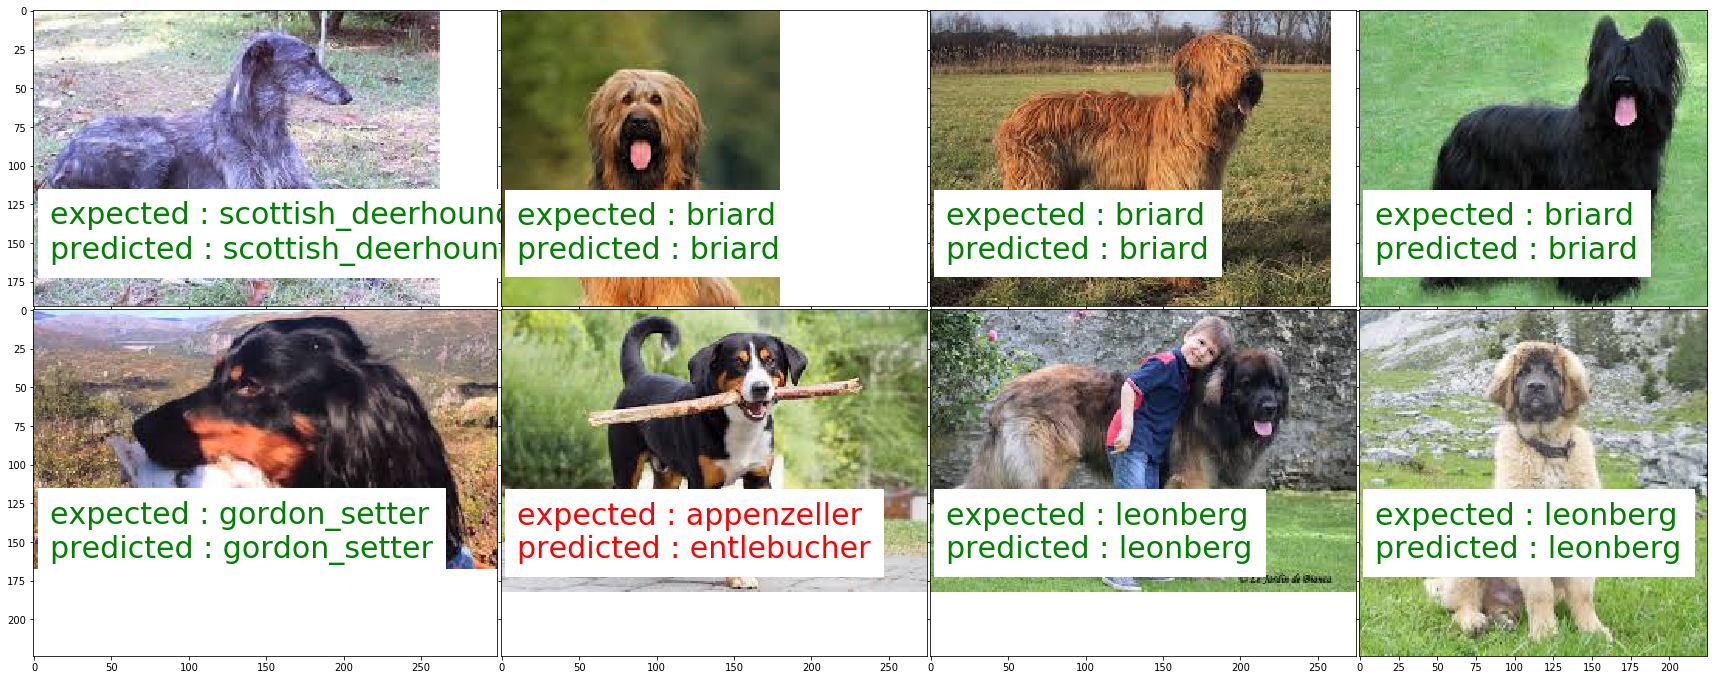

In [117]:
# print(labels_outside.id[0])
# print(label_classes)
# print(df_outside.head(1))
# top_5 = df_outside
# for index, row in df_outside.iterrows():
#      top_5[index] = row.sort_values(axis=0,ascending=False))
# print(top_5)
    
rows = 2
cols = 4
idx_arr = np.ceil(np.random.random((rows * cols)) * total_records)
fig = plt.figure(1, figsize=(30, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.05)

for i, idx in enumerate(idx_arr):
    col = i % cols
    row = i // rows
    title = "expected : " + labels_outside.breed[i] + "\n" + "predicted : " + outside_preds[i]
    image_file ="./free-form/images/" + str(labels_outside.id[i]) + ".jpg"
#     image = plt.imread(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
#     print(image_file)
    img = Image.open(image_file)
    img.thumbnail((400, 400), Image.ANTIALIAS)
    grid[i].imshow(img)
    textcolor = "green" if(labels_outside.breed[i]==outside_preds[i]) else "red"
    grid[i].text(10, 160, title, color=textcolor, backgroundcolor='w', alpha=1, fontsize=30 )
#     grid[i].text(10, 100, "description", color='b', backgroundcolor='w', alpha=0.8 )
plt.savefig("./free-form/predictions.jpg", bbox_inches="tight")
plt.show()    

#### references - 

* https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41
* https://keras.io/applications/#usage-examples-for-image-classification-models
* https://www.kaggle.com/gaborfodor/dog-breed-pretrained-keras-models-lb-0-3